<a href="https://colab.research.google.com/github/julialromero/Collaborative-Problem-Solving/blob/main/learning_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras import layers, Input, Model, optimizers

# Scratchwork

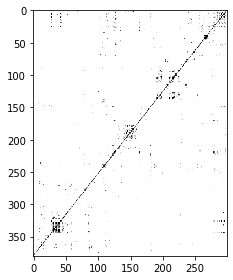

In [148]:
from skimage import io

imag = io.imread('drive/MyDrive/data/RAW/1010-ExpBlock1_RAW.png', as_gray=True)
x = image.img_to_array(imag)

x = tf.image.resize(x, imgsize)
x = np.array(x)
io.imshow(x.squeeze())
#n = preprocess_input(x)    # preprocess input for Inception v3

### (760, 598, 4)

In [150]:
# read, preprocess, and scale images to uniform dimension
imgsize = (int(760/2), int(598/2))  
def extract_image(image_path):
    imag = io.imread(image_path, as_gray=True)
    x = image.img_to_array(imag)

    x = tf.image.resize(x, imgsize)
    
    #n = preprocess_input(x)
    return x

In [7]:
# Use InceptionV3 model for feature extraction
base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(None, None, 3),
    pooling='max',
)

In [90]:
# Garcia-Ceja paper feeds CNN images with dims 100 x 100 x 4 (width x height x channels)
# Labels are one hot encoded

inputs = Input(shape=(int(760/2), int(598/2), 1))
x = layers.Conv2D(filters=16, kernel_size=3, strides=(1, 1), activation="relu")(inputs)
x = layers.Conv2D(filters=16, kernel_size=3, strides=(1, 1), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)
x = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation="relu")(x)
x = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(512, activation="relu")(x) 
x = layers.Dropout(0.50)(x)
x = layers.Flatten()(x)
out = layers.Dense(16, activation="softmax")(x) 

# ---- Output layer ----
# Try a ReLU6 activation function -> f(x) = min(max(0,x),6). Restricted between 0 and 6, inclusive.
# Then scale the range [0,6] to our target [0, 15] range and round to nearest integer

model = Model(inputs=inputs, outputs=out)
model.compile(
  optimizer = 'adam',
  loss=tf.keras.losses.CategoricalCrossentropy(), #"mse", #tf.keras.losses.MeanSquaredError(),  
  metrics=['accuracy'],
)

model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 380, 299, 1)]     0         
                                                                 
 conv2d_130 (Conv2D)         (None, 378, 297, 16)      160       
                                                                 
 conv2d_131 (Conv2D)         (None, 376, 295, 16)      2320      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 188, 147, 16)     0         
 g2D)                                                            
                                                                 
 dropout_27 (Dropout)        (None, 188, 147, 16)      0         
                                                                 
 conv2d_132 (Conv2D)         (None, 186, 145, 32)      4640      
                                                           

In [167]:
def accuracy(predicted, observed):
    if(len(predicted) != len(observed)):
        print("Error - length of input series is not equal.")
        return np.nan
    
    correct = 0
    for pred, obs in zip(predicted, observed):
        if pred == obs:
            correct += 1
    acc = correct / len(predicted)
    return acc

## Load and preprocess data

In [25]:
import os
import random

In [26]:
outcome_df = pd.read_csv("drive/MyDrive/data/team_block_outcomes.csv")

In [27]:
def extract_score(filename, outcome_df, score_col="task_score"):
    #  match this file's id/block with task score and return
    groupid, splitname = filename.split("-")
    block = splitname.split("_")[0]
    row = outcome_df.loc[(outcome_df.GROUPID == int(groupid)) & (outcome_df.block == block)]
    if(row.shape[0] != 1):
        print(f"Error -- Number of task scores recorded is not 1 for block {block} and groupid {groupid}.")
        return np.nan
    score = row[score_col].values[0]
    return score

In [151]:
# read data to np arrays
recurrence_plot_list = []
labels = []
for filename in os.listdir('drive/MyDrive/data/RAW/'):
    # preprocess image
    t = extract_image('drive/MyDrive/data/RAW/' + filename)
    
    # get task score
    lab = extract_score(filename, outcome_df, score_col="task_score")
    
    recurrence_plot_list.append(t)
    labels.append(lab)

recurrence_plot_list = np.array(recurrence_plot_list)
labels = np.array(labels)

print(f"Number of samples: {recurrence_plot_list.shape[0]}")

Number of samples: 271


In [152]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [186]:
import sklearn
from sklearn.model_selection import train_test_split

# Split into train/test/val set
# Roughly val - 15%, test - 15%, train - 70%
X_train, X_test, y_train, y_test = train_test_split(recurrence_plot_list, labels, train_size=0.85, random_state=46)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.82, random_state=46)

In [187]:
# one hot encode
enc = OneHotEncoder()
y_train_enc = enc.fit_transform(y_train.reshape(-1, 1))
#y_test_enc = enc.transform(y_test.reshape(-1, 1))
y_val_enc = enc.transform(y_val.reshape(-1, 1))

# Scale y train data from [0, 15] to [0, 6] for training the neural network
# scaler = StandardScaler()
# y_train = scaler.fit_transform(y_train.reshape(-1, 1))
# # y_train = y_train/15 * 6

# y_test_scaled = scaler.transform(y_test.reshape(-1, 1)) #/15 * 6

In [189]:
y_train_enc = y_train_enc.toarray()
#y_test_enc = y_test_enc.toarray()
y_val_enc = y_val_enc.toarray()

AttributeError: ignored

In [190]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

#callback = EarlyStopping(monitor='loss', patience=10)
mcp_save = ModelCheckpoint('.best_weights.hdf5', save_best_only=True, monitor='val_loss', mode='min')

info1 = model.fit(x=X_train, y=y_train_enc, epochs=50, verbose=True, validation_data=(X_val, y_val_enc), callbacks=[mcp_save])

Epoch 1/50
6/6 [==============================] - 6s 1s/step - loss: 0.5008 - accuracy: 0.9415 - val_loss: 0.4542 - val_accuracy: 0.9048
Epoch 2/50
6/6 [==============================] - 4s 746ms/step - loss: 0.0593 - accuracy: 1.0000 - val_loss: 0.3177 - val_accuracy: 0.9524
Epoch 3/50
6/6 [==============================] - 4s 715ms/step - loss: 0.0202 - accuracy: 1.0000 - val_loss: 0.2984 - val_accuracy: 0.9524
Epoch 4/50
6/6 [==============================] - 1s 236ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.3644 - val_accuracy: 0.9286
Epoch 5/50
6/6 [==============================] - 1s 225ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.4318 - val_accuracy: 0.9286
Epoch 6/50
6/6 [==============================] - 1s 224ms/step - loss: 5.3958e-04 - accuracy: 1.0000 - val_loss: 0.3793 - val_accuracy: 0.9286
Epoch 7/50
6/6 [==============================] - 1s 232ms/step - loss: 3.3859e-04 - accuracy: 1.0000 - val_loss: 0.3379 - val_accuracy: 0.9524
Epoch 8/50
6/6 

In [192]:
model.load_weights(filepath = '.best_weights.hdf5')

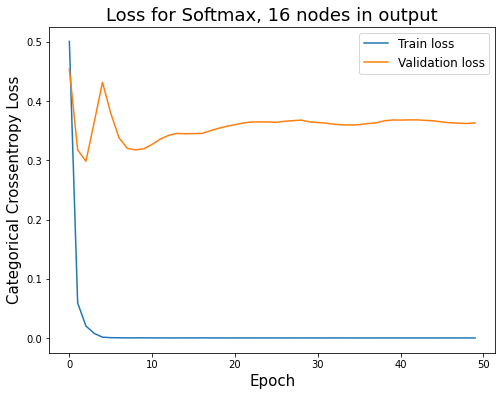

In [200]:
epochs = [i for i in range(len(info1.history['accuracy']))]
plt.figure(figsize=(8,6))
plt.plot(epochs, info1.history['loss'], label="Train loss")
plt.plot(epochs, info1.history['val_loss'], label="Validation loss")
plt.legend(fontsize=12)
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Categorical Crossentropy Loss", fontsize=15)
plt.title("Loss for Softmax, 16 nodes in output", fontsize=18)
plt.savefig('drive/MyDrive/data/results/Softmax_categorical')

In [201]:
# now calculate the actual accuracy
test_predictions = model.predict(X_test)
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)

# scale to our target range [0, 15]
# scaled_predictions = scaler.inverse_transform(test_predictions) #/6 * 15

# # round to nearest int
# final_pred = np.array([round(i) for i in scaled_predictions])

In [202]:
final_pred = enc.inverse_transform(test_predictions)
final_train_pred = enc.inverse_transform(train_predictions)
final_val_pred = enc.inverse_transform(val_predictions)

In [220]:
test_acc = accuracy(final_pred, y_test)
train_acc = accuracy(final_train_pred, y_train)
val_acc = accuracy(final_val_pred, y_val)
print("----Results----")
print(f"Size of train set: {y_train.shape[0]}")
print(f"Train acc: {train_acc}")
print(f"----\nSize of validation set: {y_val.shape[0]}")
print(f"Validation acc: {val_acc}")
print(f"----\nSize of test set: {y_test.shape[0]}")
print(f"Test acc: {test_acc}")

----Results----
Size of train set: 188
Train acc: 1.0
----
Size of validation set: 42
Validation acc: 0.9523809523809523
----
Size of test set: 41
Test acc: 0.975609756097561


In [212]:
(final_pred == y_test)#.sum()

array([[ True,  True, False, ..., False, False, False],
       [ True,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

In [219]:
(y_test.reshape(-1, 1) == final_pred).sum()

40